# Airbnb Project

### Content
The following Airbnb activity is included in this Seattle dataset:

- Listings, including full descriptions and average review score
- Reviews, including unique id for each reviewer and detailed comments
- Calendar, including listing id and the price and availability for that day

### Inspiration
- Can you describe the vibe of each Seattle neighborhood using listing descriptions?
- What are the busiest times of the year to visit Seattle? By how much do prices spike?
- Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?

### My questions
- What are the most expensive neigbourhoods in Seattle ? how are the occupancies of these ?
- Pricing model: Can I perform a prognose of the price of the apartment based on location, properties (frunishment, rooms, sqm, etc.), time, ... ?
- Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?

### Import of libraries and data

In [78]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)

# Import files:
df_calendar = pd.read_csv('./data/archive/calendar.csv')
df_listings = pd.read_csv('./data/archive/listings.csv')
df_reviews = pd.read_csv('./data/archive/reviews.csv')

# Check rows x columns of data:
print("df_listings:" + str(df_listings.shape))
print("df_calendar:" + str(df_calendar.shape))
print("df_reviews:" + str(df_reviews.shape))
print("-------------")

# Rename columns:
df_listings.rename(columns={'id': 'listing_id'}, inplace=True)
df_listings.rename(columns={'price': 'price_room'}, inplace=True)
#Would rather use that for a LLM-Anaylsis
#df_reviews["date"] = pd.to_datetime(df_reviews["date"], format='%Y-%m-%d')

# Create list of dfs to integrate in future loops:
df_vec = [df_calendar, df_listings, df_reviews]

# Convert date columns to proper datetime-type:
df_calendar["date"] = pd.to_datetime(df_calendar["date"], format='%Y-%m-%d')
df_listings["host_since"] = pd.to_datetime(df_listings["host_since"], format='%Y-%m-%d')

# Converting the %-Values from String to Float:
df_listings["host_response_rate"] = df_listings["host_response_rate"].astype(str).str.replace('%', '').str.replace(',', '').astype(float)
df_listings["host_acceptance_rate"] = df_listings["host_acceptance_rate"].astype(str).str.replace('%', '').str.replace(',', '').astype(float)

# Converting the $-Values from String to Float:
df_calendar["price"] = df_calendar["price"].astype(str).str.replace("$", "").str.replace(",", "").astype(float)
#df_listings['weekly_price'] = df_listings['weekly_price'].astype(str).str.replace('$', '').str.replace(',', '').astype(float)
dollars = ["price_room", "security_deposit", "cleaning_fee", "extra_people"]
for dollar in dollars:
    df_listings[dollar] = df_listings[dollar].astype(str).str.replace("$", "").str.replace(",", "").astype(float)

# Separation into relevant numeric and categoric data:
df_cal_list_num = df_listings[["accommodates", "number_of_reviews", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value", "bathrooms", "bedrooms", "beds", "guests_included", "minimum_nights", "maximum_nights", "security_deposit", "cleaning_fee", "extra_people", "host_response_rate", "host_acceptance_rate"]]
#df_listings_cat = df_listings.select_dtypes(include=["object"])
df_cal_list_cat = df_listings[["listing_id", "cancellation_policy", "neighbourhood", "host_identity_verified", "host_has_profile_pic", "property_type", "room_type", "bed_type", "cancellation_policy", "require_guest_profile_picture", "require_guest_phone_verification", "instant_bookable", "host_response_time", "host_is_superhost"]]

# Combination of num and cat variables:
df_new = pd.concat([df_cal_list_num, df_cal_list_cat], axis =1)
#df_new = df_new.dropna()

# Combination of "relevant" listing and calendar df:
df_new = pd.merge(df_new, df_calendar, on='listing_id', how='left')
df_new = df_new.drop("listing_id", axis=1)
#df_new = df_new.dropna(subset=["price", "property_type", "beds", "bedrooms", "bathrooms"])

print(df_new)
print(df_new.isnull().sum()/df_new.shape[0])
df_new.head()

df_listings:(3818, 92)
df_calendar:(1393570, 4)
df_reviews:(84849, 6)
-------------
         accommodates  number_of_reviews  review_scores_accuracy  \
0                   4                207                    10.0   
1                   4                207                    10.0   
2                   4                207                    10.0   
3                   4                207                    10.0   
4                   4                207                    10.0   
...               ...                ...                     ...   
1393565             3                  0                     NaN   
1393566             3                  0                     NaN   
1393567             3                  0                     NaN   
1393568             3                  0                     NaN   
1393569             3                  0                     NaN   

         review_scores_cleanliness  review_scores_checkin  \
0                             10.0    

,accommodates,number_of_reviews,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,security_deposit,cleaning_fee,extra_people,host_response_rate,host_acceptance_rate,cancellation_policy,neighbourhood,host_identity_verified,host_has_profile_pic,property_type,room_type,bed_type,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,instant_bookable,host_response_time,host_is_superhost,date,available,price
0,4,207,10.0,10.0,10.0,10.0,9.0,10.0,1.0,1.0,1.0,2,1,365,NaN,NaN,5.0,96.0,100.0,moderate,Queen Anne,t,t,Apartment,Entire home/apt,Real Bed,moderate,f,f,f,within a few hours,f,2016-01-04,t,85.0
1,4,207,10.0,10.0,10.0,10.0,9.0,10.0,1.0,1.0,1.0,2,1,365,NaN,NaN,5.0,96.0,100.0,moderate,Queen Anne,t,t,Apartment,Entire home/apt,Real Bed,moderate,f,f,f,within a few hours,f,2016-01-05,t,85.0
2,4,207,10.0,10.0,10.0,10.0,9.0,10.0,1.0,1.0,1.0,2,1,365,NaN,NaN,5.0,96.0,100.0,moderate,Queen Anne,t,t,Apartment,Entire home/apt,Real Bed,moderate,f,f,f,within a few hours,f,2016-01-06,f,NaN
3,4,207,10.0,10.0,10.0,10.0,9.0,10.0,1.0,1.0,1.0,2,1,365,NaN,NaN,5.0,96.0,100.0,moderate,Queen Anne,t,t,Apartment,Entire home/apt,Real Bed,moderate,f,f,f,within a few hours,f,2016-01-07,f,NaN
4,4,207,10.0,10.0,10.0,10.0,9.0,10.0,1.0,1.0,1.0,2,1,365,NaN,NaN,5.0,96.0,100.0,moderate,Queen Anne,t,t,Apartment,Entire home/apt,Real Bed,moderate,f,f,f,within a few hours,f,2016-01-08,f,NaN


In [79]:
df_listings["amenities"].unique()

array(['{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,Heating,"Family/Kid Friendly",Washer,Dryer}',
       '{TV,Internet,"Wireless Internet",Kitchen,"Free Parking on Premises","Buzzer/Wireless Intercom",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","First Aid Kit","Safety Card","Fire Extinguisher",Essentials}',
       '{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,"Free Parking on Premises","Pets Allowed","Pets live on this property",Dog(s),Cat(s),"Hot Tub","Indoor Fireplace",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector",Essentials,Shampoo}',
       ...,
       '{"Cable TV","Wireless Internet",Kitchen,"Free Parking on Premises",Breakfast,"Pets live on this property",Dog(s),Cat(s),Heating,Washer,Dryer,"Smoke Detector","First Aid Kit","Safety Card","Fire Extinguisher",Essentials,Hangers,"Hair Dryer",Iron,"Laptop Friendly Workspace"}',
       '{TV,"Wireless I

<Axes: >

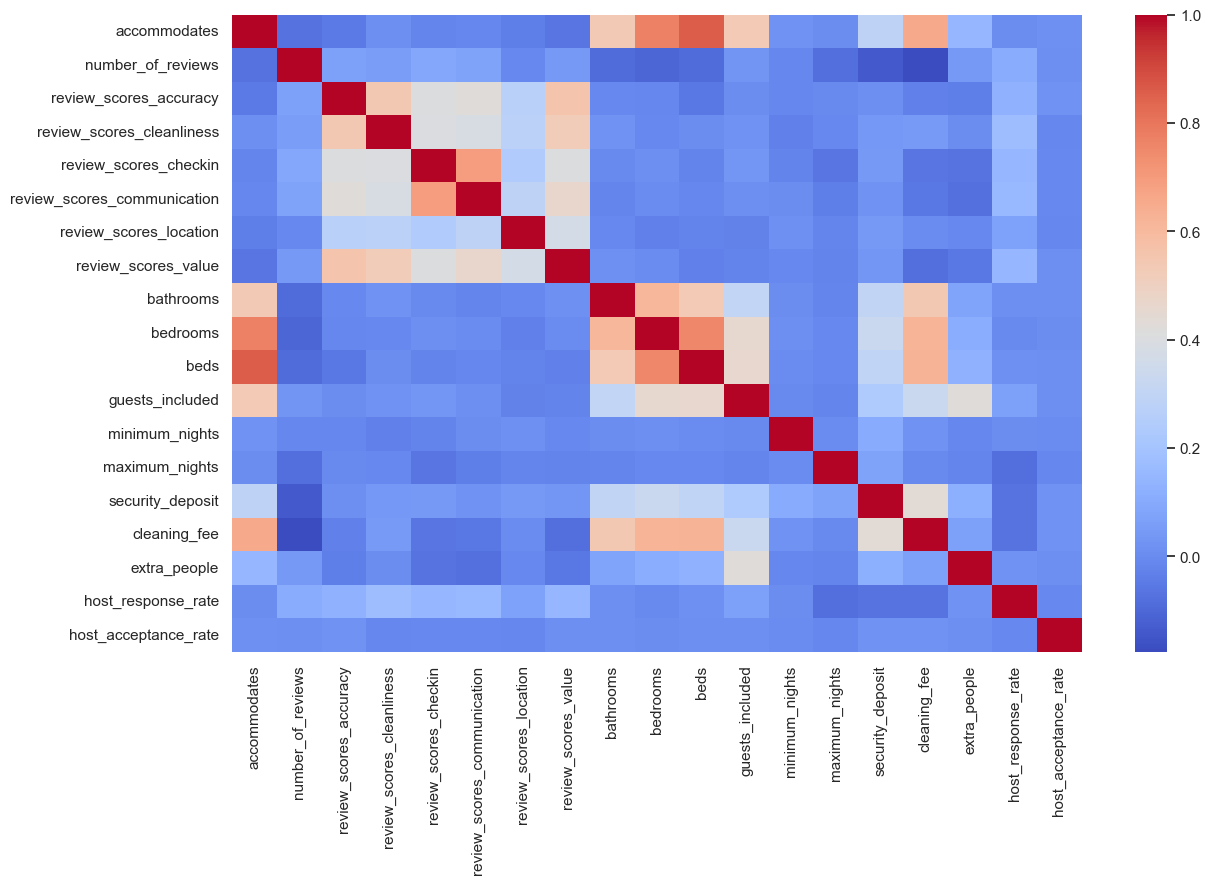

In [80]:
df_listings_corr_matrix = df_cal_list_num.corr()
sns.heatmap(df_listings_corr_matrix, cmap='coolwarm', fmt='.2f')

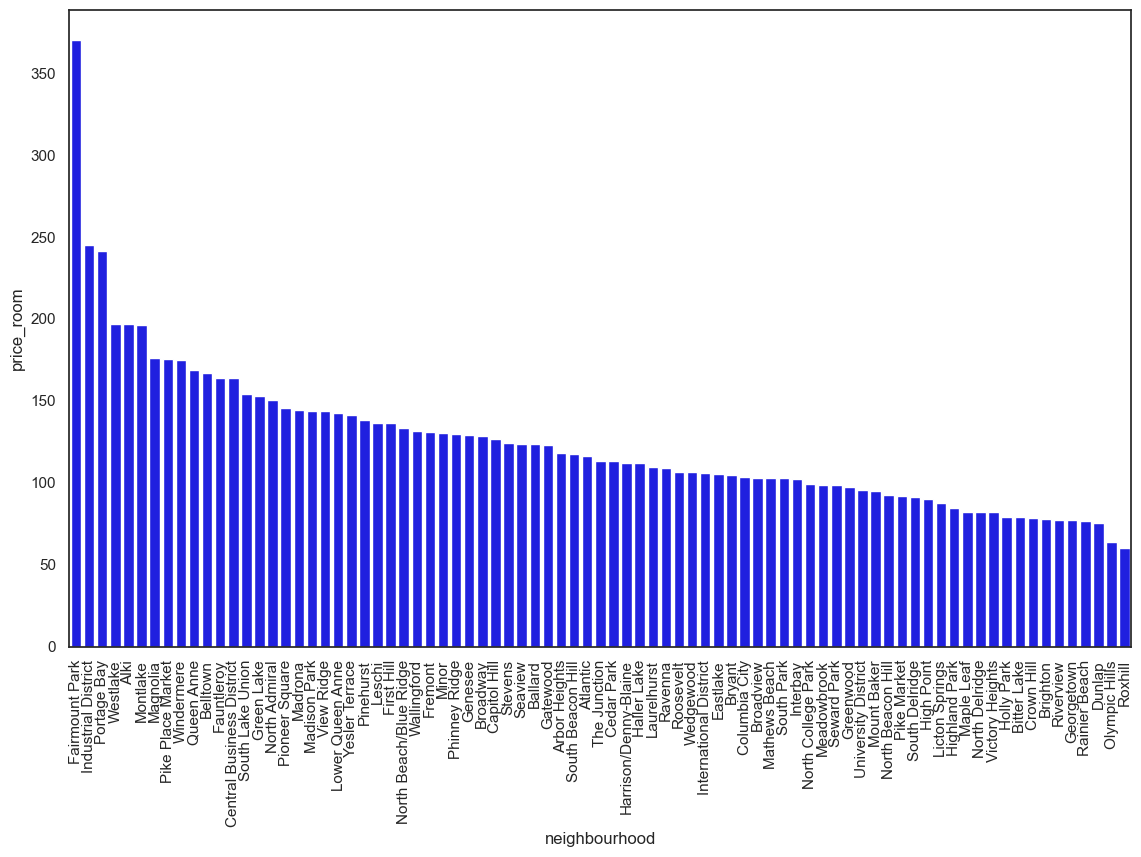

In [81]:
df_neighbourhood_prices = df_listings[["neighbourhood", "price_room"]]
df_neighbourhood_prices = df_neighbourhood_prices.groupby("neighbourhood").mean().reset_index()
df_neighbourhood_prices = df_neighbourhood_prices.sort_values(by="price_room", ascending=False)
sns.set_theme(style="white", rc={'figure.figsize':(13.7,8.27)})
fig, ax = plt.subplots()
neighbourhood_prices = sns.barplot(x="neighbourhood", y="price_room", data=df_neighbourhood_prices, color="blue", ax=ax)
ax.set_axisbelow(True)
ax.grid(False)
neighbourhood_prices.set_xticklabels(neighbourhood_prices.get_xticklabels(), rotation=90);

In [82]:
df_new[df_new["neighbourhood"] == "Roxhill"]

,accommodates,number_of_reviews,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,security_deposit,cleaning_fee,extra_people,host_response_rate,host_acceptance_rate,cancellation_policy,neighbourhood,host_identity_verified,host_has_profile_pic,property_type,room_type,bed_type,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,instant_bookable,host_response_time,host_is_superhost,date,available,price
1274215,2,2,10.0,10.0,10.0,10.0,10.0,10.0,1.0,1.0,1.0,1,1,1125,NaN,NaN,30.0,NaN,NaN,flexible,Roxhill,t,t,House,Private room,Real Bed,flexible,f,f,f,NaN,f,2016-01-04,t,60.0
1274216,2,2,10.0,10.0,10.0,10.0,10.0,10.0,1.0,1.0,1.0,1,1,1125,NaN,NaN,30.0,NaN,NaN,flexible,Roxhill,t,t,House,Private room,Real Bed,flexible,f,f,f,NaN,f,2016-01-05,t,60.0
1274217,2,2,10.0,10.0,10.0,10.0,10.0,10.0,1.0,1.0,1.0,1,1,1125,NaN,NaN,30.0,NaN,NaN,flexible,Roxhill,t,t,House,Private room,Real Bed,flexible,f,f,f,NaN,f,2016-01-06,t,60.0
1274218,2,2,10.0,10.0,10.0,10.0,10.0,10.0,1.0,1.0,1.0,1,1,1125,NaN,NaN,30.0,NaN,NaN,flexible,Roxhill,t,t,House,Private room,Real Bed,flexible,f,f,f,NaN,f,2016-01-07,t,60.0
1274219,2,2,10.0,10.0,10.0,10.0,10.0,10.0,1.0,1.0,1.0,1,1,1125,NaN,NaN,30.0,NaN,NaN,flexible,Roxhill,t,t,House,Private room,Real Bed,flexible,f,f,f,NaN,f,2016-01-08,t,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274575,2,2,10.0,10.0,10.0,10.0,10.0,10.0,1.0,1.0,1.0,1,1,1125,NaN,NaN,30.0,NaN,NaN,flexible,Roxhill,t,t,House,Private room,Real Bed,flexible,f,f,f,NaN,f,2016-12-29,t,60.0
1274576,2,2,10.0,10.0,10.0,10.0,10.0,10.0,1.0,1.0,1.0,1,1,1125,NaN,NaN,30.0,NaN,NaN,flexible,Roxhill,t,t,House,Private room,Real Bed,flexible,f,f,f,NaN,f,2016-12-30,t,60.0
1274577,2,2,10.0,10.0,10.0,10.0,10.0,10.0,1.0,1.0,1.0,1,1,1125,NaN,NaN,30.0,NaN,NaN,flexible,Roxhill,t,t,House,Private room,Real Bed,flexible,f,f,f,NaN,f,2016-12-31,t,60.0
1274578,2,2,10.0,10.0,10.0,10.0,10.0,10.0,1.0,1.0,1.0,1,1,1125,NaN,NaN,30.0,NaN,NaN,flexible,Roxhill,t,t,House,Private room,Real Bed,flexible,f,f,f,NaN,f,2017-01-01,t,60.0


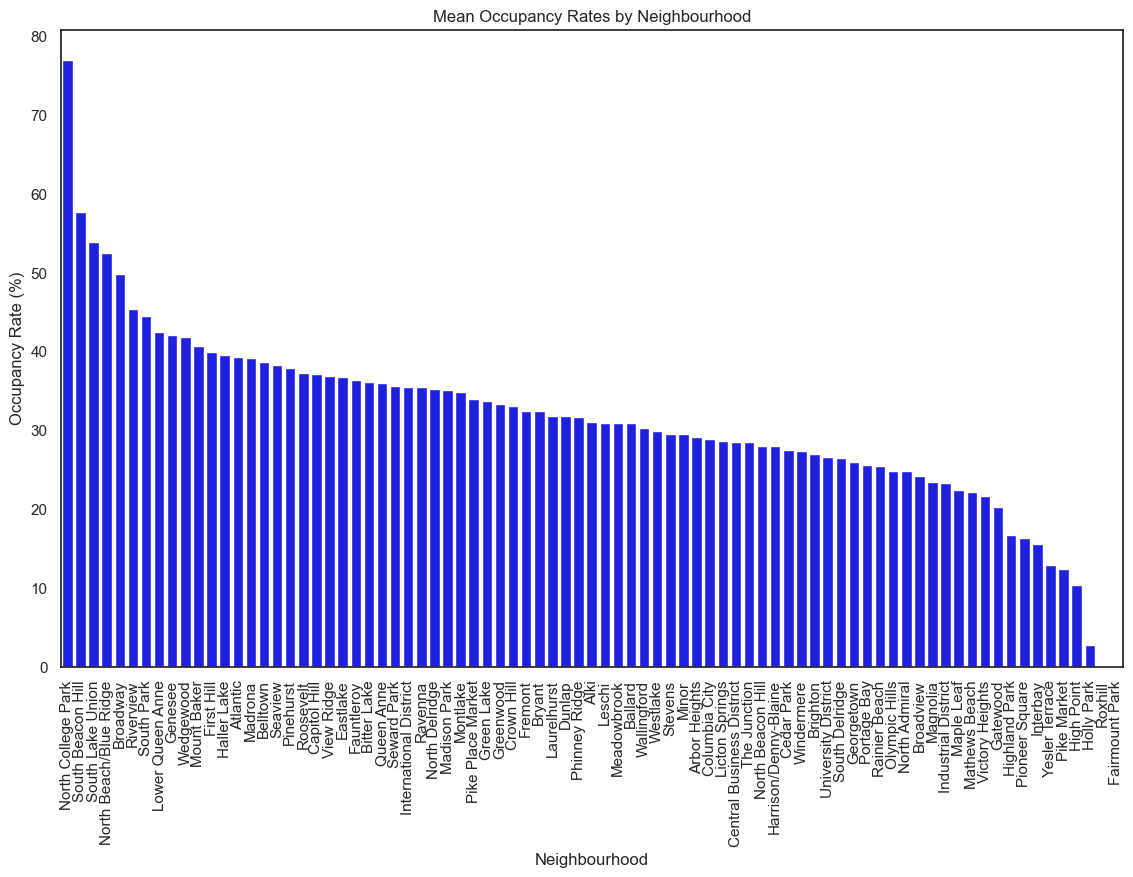

In [83]:
# Calculate monthly occupancy rate per neighbourhood
df_monthly_occup_ratio = (
    df_new
    .groupby(["neighbourhood", pd.Grouper(key="date", freq="M")])["available"]
    .apply(lambda x: (1 - (x == "t").sum() / len(x)) * 100)
    .reset_index()
)

# Calculate the mean occupancy rate per neighbourhood
df_neighbourhood_occup = df_monthly_occup_ratio.groupby("neighbourhood")["available"].mean().reset_index()
df_neighbourhood_occup = df_neighbourhood_occup.sort_values(by="available", ascending=False)

# Create the plot
sns.set_theme(style="white", rc={'figure.figsize':(13.7,8.27)})
fig, ax = plt.subplots()
neighbourhood_occup = sns.barplot(x="neighbourhood", y="available", data=df_neighbourhood_occup, color="blue", ax=ax)
ax.set_axisbelow(True)
ax.grid(False)
neighbourhood_occup.set_xticklabels(neighbourhood_occup.get_xticklabels(), rotation=90)
ax.set_title("Mean Occupancy Rates by Neighbourhood")
ax.set_xlabel("Neighbourhood")
ax.set_ylabel("Occupancy Rate (%)")
plt.show()

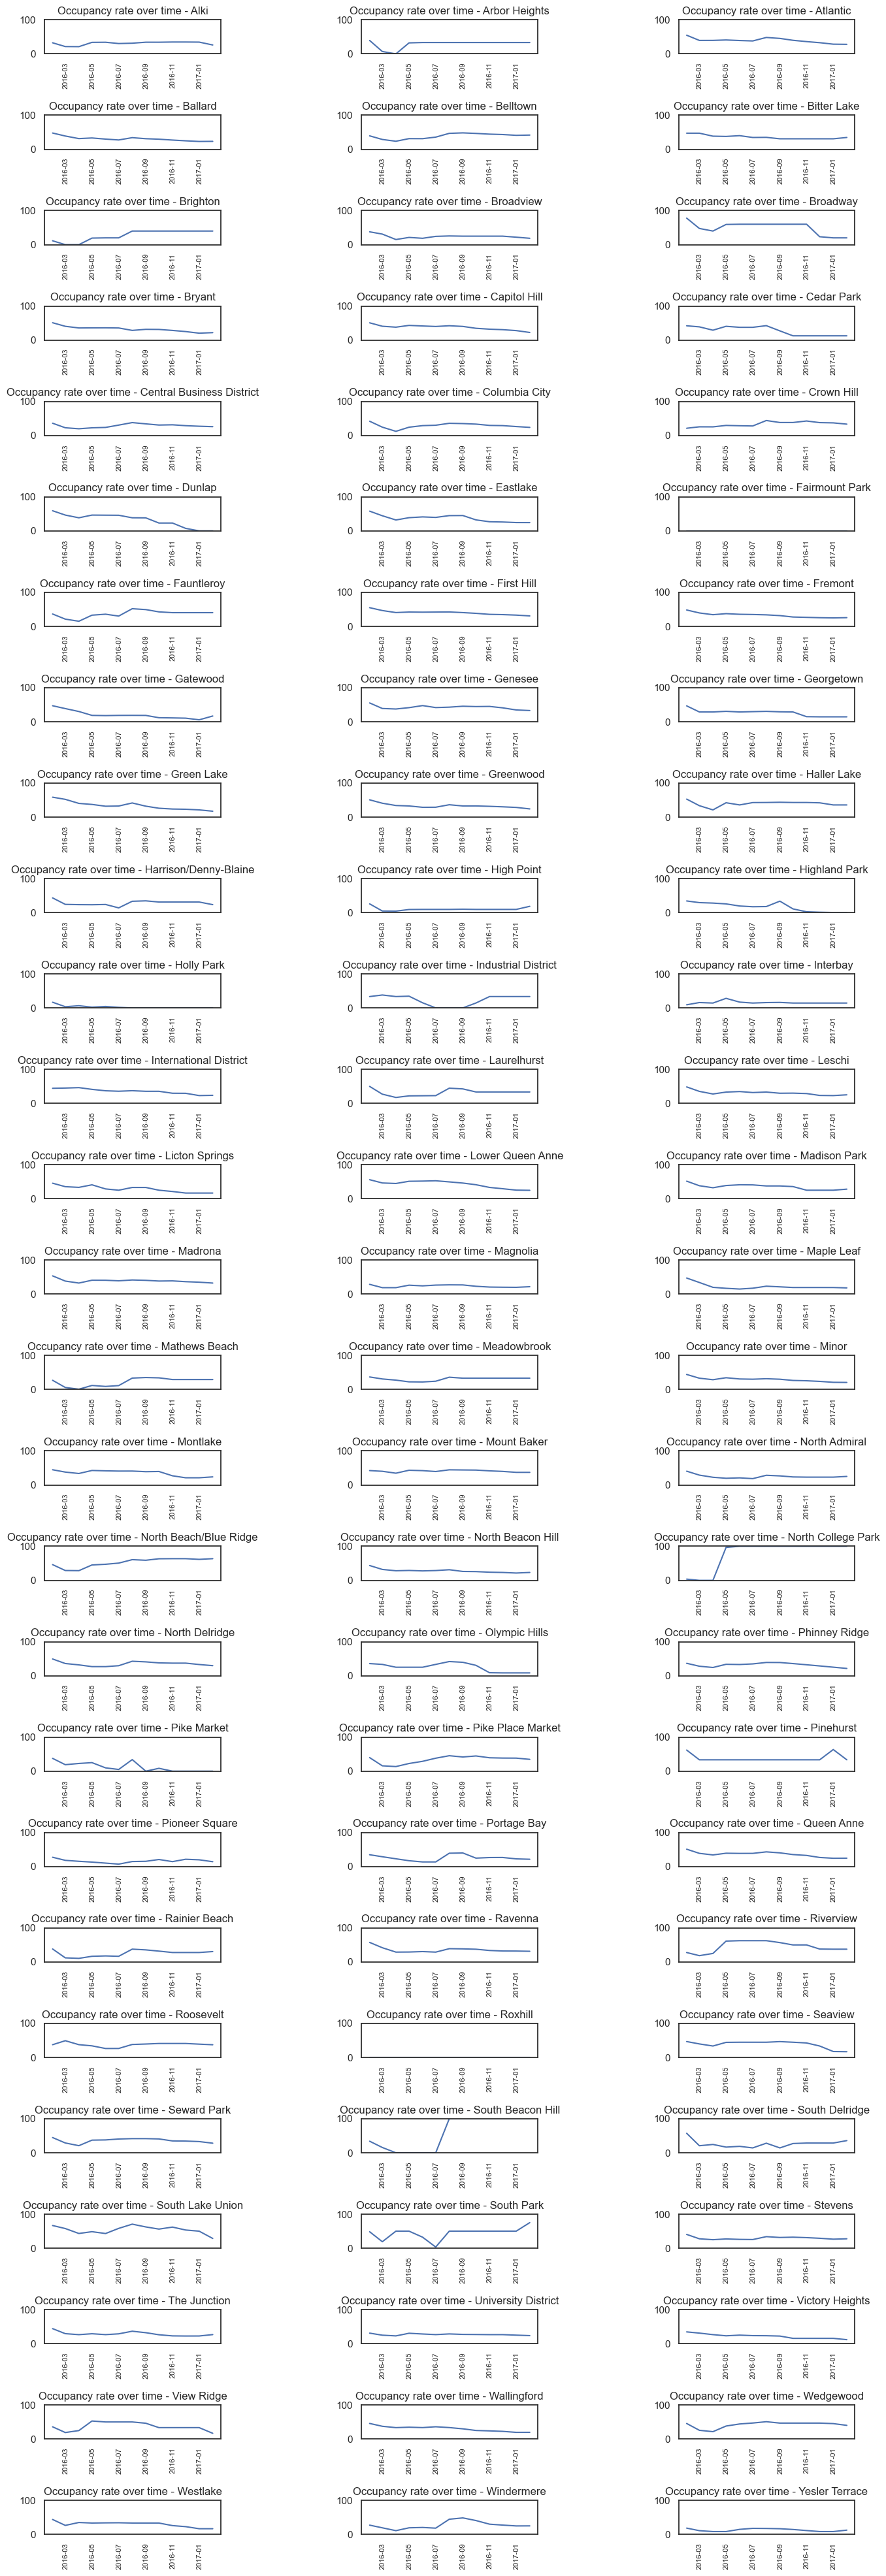

In [84]:
# Get the unique neighbourhoods
neighbourhoods = df_monthly_occup_ratio["neighbourhood"].unique()

# Calculate the number of rows and columns for the grid layout
num_plots = len(neighbourhoods)
num_cols = 3
num_rows = math.ceil(num_plots / num_cols)

# Create a figure with grid layout
fig = plt.figure(figsize=(16, 50))
gs = fig.add_gridspec(num_rows, num_cols, wspace=0.8, hspace=1.8)

# Loop through the neighbourhoods and plot the occupancy rate
for i, neighbourhood in enumerate(neighbourhoods):
    ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
    df_occup = df_monthly_occup_ratio[df_monthly_occup_ratio["neighbourhood"] == neighbourhood]
    ax.plot(df_occup["date"], df_occup["available"])
    #ax.set_ylabel("Occupancy rate in %")
    ax.set_title(f"Occupancy rate over time - {neighbourhood}")
    ax.set_ylim(0, 100)  # Set the y-axis limits to 0-100 for better visibility
    ax.tick_params(axis='x', which='major', rotation=90, labelsize=8)  # Reduce the font size of the tick labels
plt.show()

### How did unique listings change over time ?
Notes:
- The value is constant over a year, probably meaning, that listings that did not exist yet were included with their id while the value of availability was set to "f" and price to NaN to keep the total amount of listings constant over time

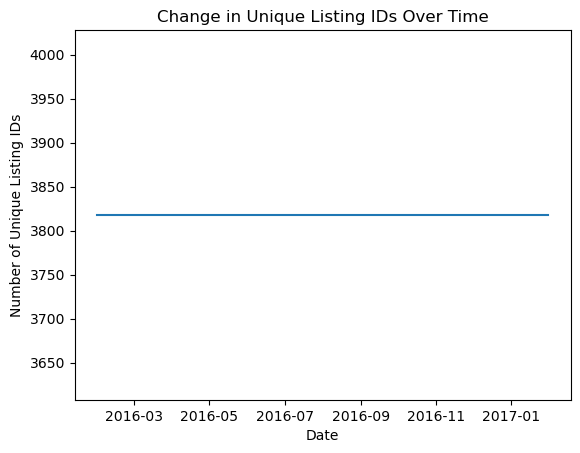

In [16]:
unique_listings_over_time = df_calendar.resample('M', on='date')['listing_id'].nunique()
unique_listings_over_time

plt.plot(unique_listings_over_time.index, unique_listings_over_time.values)
plt.xlabel('Date')
plt.ylabel('Number of Unique Listing IDs')
plt.title('Change in Unique Listing IDs Over Time')
plt.show()

### How did the occupancy rate change over time ?
Notes:
- It looks like the amount of people coming to Seattle to stay at Airbnbs is increasing over time, while there has been a drop in mid 2016

In [74]:
df_calendar_f = df_calendar[df_calendar["available"] == "f"]
df_calendar_t = df_calendar[df_calendar["available"] == "t"]
df_calendar_NaNfill = df_calendar.fillna(0)
df_calendar_f.isnull().sum()/df_calendar.shape[0]

# "available" = "f" means that the place was not booked and therefore there is no price data
# It would be interesting to see the ratio of f/t over time --> Think about a plot here

listing_id    0.00000
date          0.00000
available     0.00000
price         0.32939
dtype: float64

### Analysis of the mean price and occupancy over time in calendar data
- Occupation rates in summer higher than winter.
- 2015 seemed to have drawn more people into Airbnbs in Seattle than 2016

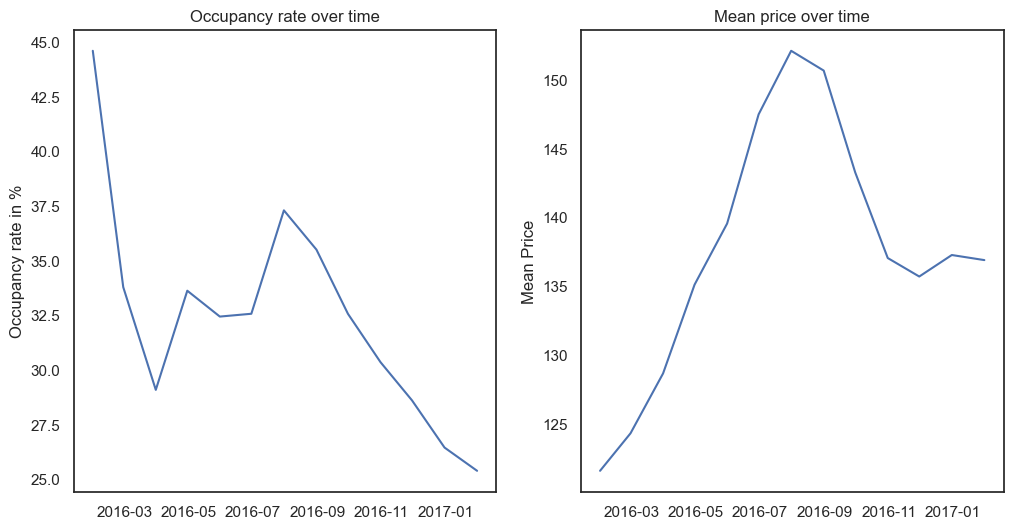

In [75]:
df_monthly_occup_ratio = df_calendar.resample("M", on="date")["available"].apply(lambda x: (1 - (x == "t").sum() / len(x)) * 100)
df_monthly_mean_price = df_calendar_t[["price","date"]].resample("M", on="date").mean()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(df_monthly_occup_ratio.index, df_monthly_occup_ratio.values)
plt.ylabel("Occupancy rate in %")
plt.title("Occupancy rate over time")

plt.subplot(1, 2, 2)
plt.plot(df_monthly_mean_price.index, df_monthly_mean_price["price"])
plt.ylabel("Mean Price")
plt.title("Mean price over time")

plt.show()

In [37]:
#Pull a list of the column names of the categorical variables
cat_cols_lst = df_cal_list_cat.columns

def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [148]:
# Drop and available date column
df_new = df_new.drop(["date", "available"], axis=1)

# Drop NaN
df_new = df_new.dropna(subset=["price", "property_type", "beds", "bedrooms", "bathrooms"])

#Create dummies for categoric variables
df_new = create_dummy_df(df_new, df_cal_list_cat, dummy_na=False)

# Fill the mean (not applied, as dropping NaN-values makes more sense for the chosen data)
#fill_mean = lambda col: col.fillna(col.mean())
#df_new = df_new.apply(fill_mean, axis=0)

df_new = df_new.dropna()

#Split into explanatory and response variables
y = df_new.pop("price")
X = df_new

print(df_new.isnull().sum()/df_new.shape[0])

accommodates                             0.0
number_of_reviews                        0.0
review_scores_accuracy                   0.0
review_scores_cleanliness                0.0
review_scores_checkin                    0.0
                                        ... 
instant_bookable_t                       0.0
host_response_time_within a day          0.0
host_response_time_within a few hours    0.0
host_response_time_within an hour        0.0
host_is_superhost_t                      0.0
Length: 132, dtype: float64


In [149]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=1)

lm_model = LinearRegression() # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict and score the model
y_test_preds = lm_model.predict(X_test)
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model using only quantitative variables was 0.7275067963149708 on 92647 values.'